# Install Pyrender

In [ ]:
# Install dependencies - OSMesa, mmatl's fork of PyOpenGL
!sudo apt update
!sudo wget https://github.com/mmatl/travis_debs/raw/master/xenial/mesa_18.3.3-0.deb
!sudo dpkg -i ./mesa_18.3.3-0.deb || true
!sudo apt install -f
!git clone https://github.com/mmatl/pyopengl.git
!pip install ./pyopengl
# Install pyrender
!pip install pyrender

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:6 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:11 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic/main Sources [1,827 kB]
Ign:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:13 https://developer.download

# Set-up
Loading libraries and network model

In [ ]:
# Render offscreen -- make sure to set the PyOpenGL platform
import os
os.environ["PYOPENGL_PLATFORM"] = "osmesa"
import pyrender

import trimesh
import cv2  
from google.colab.patches import cv2_imshow

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)
print(tf.test.gpu_device_name())

import sys
import numpy as np
import json
import os
import sys
import time
import shutil

sys.path.append("/content/drive/My Drive/COLAB/COLAB_SRC/")

import provider
#import cuneiform_network as model
#import cuneiform_paper_network as model

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

TensorFlow 1.x selected.
1.15.2
/device:GPU:0
Wed Feb 23 14:43:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    38W / 300W |    309MiB / 16160MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                          

In [ ]:
# !pip install open3d
# import open3d as o3d

In [ ]:
import tf_util

def get_model_0x000010(point_cloud, input_label, is_training, cat_num, part_num, \
		batch_size, num_point, weight_decay, bn_decay=None, use_bn=True,
		  k = 20, groups = 32, features = 1024, conv_feat = 64):
  """ ConvNet baseline, input is BxNxF point cloud """
  end_points = {}

  batch_size = point_cloud.get_shape()[0].value
  num_point = point_cloud.get_shape()[1].value
  
  #with tf.name_scope("processing"):
  with tf.variable_scope('pro/edge_2') as sc:
      input_image = tf.expand_dims(point_cloud, -1)
      adj = tf_util.pairwise_distance(point_cloud[:,:,:])
      #nn_idx = tf_util.knn(adj, k=k)
      nn_idx, values = knn_range(adj, k=k, search_range=60)
      # nn_idx, values = knn_range(adj, k=k)
      #nn_idx_geom = knn_rand(adj, k=k)
      edge_feature_2 = tf_util.get_edge_feature(input_image, nn_idx=nn_idx, k=k)#, scope='pro/edge2')
      #edge_feature_2_geom = tf_util.get_edge_feature(input_image, nn_idx=nn_idx_geom, k=k)#, scope='pro/edge2')


  out1 = tf_util.conv2d(edge_feature_2, conv_feat, [1,1],
                       padding='VALID', stride=[1,1],
                       bn=use_bn, is_training=is_training, weight_decay=weight_decay,
                       scope='pro/adj_conv1', bn_decay=bn_decay, activation_fn=tf.nn.elu)
  
  out1 =  tf.contrib.layers.group_norm(out1, groups=groups, scope='pro/gn_1')
  
  with tf.variable_scope('pro/red_1') as sc:
    net_1 = tf.reduce_max(out1, axis=-2, keep_dims=True) # , scope='pro/red1'
    # net_1 = tf.reduce_mean(out1, axis=-2, keep_dims=True) # , scope='pro/red1'

  #print( "net_1", net_1 )

  with tf.variable_scope('pro/edge_3') as sc:
      #adj = tf_util.pairwise_distance(net_1)
      #nn_idx = tf_util.knn(adj, k=k)
      print(adj)
      print(values)
      values_mean_3 = tf.reduce_mean(values[:,:,-1])
      #values_mean_3 = tf.reduce_mean(values[:,:,0])

      #print(values_mean)
      #adj = tf.where(tf.math.less_equal(adj, values_mean), adj, tf.zeros_like(adj) - 100000000000)
      #adj = tf.where(tf.math.less_equal(adj, values_mean), adj, tf.zeros_like(adj))
      
      #adj = -tf.nn.relu(-adj-values_mean)
      
      #adj is negative
      
      #adj = adj + (tf.nn.relu(-adj-values_mean)*100000000)
      adj = adj + (tf.round(tf.nn.sigmoid(-adj-values_mean_3))*100000000)
      
      nn_idx, values = knn_range(adj, k=k, search_range=60) # knn_range(adj, k=k) #
      # nn_idx, values = knn_range(adj, k=k) # knn_range(adj, k=k) #
      
      print(values)
      #edge_feature_3_geom = tf_util.get_edge_feature(net_1, nn_idx=nn_idx_geom, k=k)#, scope='pro/edge3') i
      edge_feature_3 = tf_util.get_edge_feature(net_1, nn_idx=nn_idx, k=k)#, scope='pro/edge3')
      
  out3 = tf_util.conv2d(edge_feature_3, conv_feat, [1,1],
                       padding='VALID', stride=[1,1],
                       bn=use_bn, is_training=is_training, weight_decay=weight_decay,
                       scope='pro/adj_conv3', bn_decay=bn_decay, activation_fn=tf.nn.elu)

  #out3_geom = tf_util.conv2d(edge_feature_3_geom, conv_feat, [1,1],
  #                     padding='VALID', stride=[1,1],
  #                     bn=use_bn, is_training=is_training, weight_decay=weight_decay,
  #                     scope='pro/adj_conv3_geom', bn_decay=bn_decay)

  out3 =  tf.contrib.layers.group_norm(out3, groups=groups, scope='pro/gn_3')

  with tf.variable_scope('pro/red_2') as sc:
    net_2 = tf.reduce_max(out3, axis=-2, keep_dims=True)
  #   # net_2 = tf.reduce_mean(out3, axis=-2, keep_dims=True)

  # with tf.variable_scope('pro/red_2') as sc:
  #   net_2_max = tf.reduce_max(out3, axis=-2, keep_dims=True)
  #   net_2_mean = tf.reduce_mean(out3, axis=-2, keep_dims=True)
  #   net_2 = tf.concat([net_2_max, net_2_mean], axis=-1)

  # with tf.variable_scope('pro/edge_4') as sc:
  #     #adj = tf_util.pairwise_distance(net_2)
  #     #nn_idx = tf_util.knn(adj, k=k)
      
  #     values_mean_4 = tf.reduce_mean(values[:,:,-1]) # the mean value is 
  #     #values_mean_4 = tf.reduce_mean(values[:,:,0])
  #     #adj = adj + (tf.nn.relu(-adj-values_mean)*100000000) # return -x if x > y else  -x + (-x+y)*k
  #     adj = adj + (tf.round(tf.nn.sigmoid(-adj-values_mean_4))*100000000)
     
     
  #     nn_idx, values =  knn_range(adj, k=k, search_range=60) # knn_range(adj, k=k) # 
  #     #edge_feature_4_geom = tf_util.get_edge_feature(net_2, nn_idx=nn_idx_geom, k=k)#, scope='pro/edge4')
  #     edge_feature_4 = tf_util.get_edge_feature(net_2, nn_idx=nn_idx, k=k)#, scope='pro/edge4')
  #     values_mean_5 = tf.reduce_mean(values[:,:,-1])
  #     #values_mean_5 = tf.reduce_mean(values[:,:,0])
      

  # out5 = tf_util.conv2d(edge_feature_4, conv_feat, [1,1],
  #                      padding='VALID', stride=[1,1],
  #                      bn=use_bn, is_training=is_training, weight_decay=weight_decay,
  #                      scope='pro/adj_conv5', bn_decay=bn_decay)

  # #out5_geom = tf_util.conv2d(edge_feature_4_geom, conv_feat, [1,1],
  # #                     padding='VALID', stride=[1,1],
  # #                     bn=use_bn, is_training=is_training, weight_decay=weight_decay,
  # #                     scope='pro/adj_conv5_geom', bn_decay=bn_decay)

  # out5 =  tf.contrib.layers.group_norm(out5, groups=groups, scope='pro/gn_5')

  # with tf.variable_scope('pro/red_3') as sc:
  #   #net_3 = tf.reduce_max(out5, axis=-2, keep_dims=True) #,scope='pro/red3')
  #   net_3 = tf.reduce_max(out5, axis=-2, keep_dims=True) #,scope='pro/red3')

  out7 = tf_util.conv2d(tf.concat([net_1, net_2], axis=-1, name='pro/concat'), 1024, [1, 1], 
                       padding='VALID', stride=[1,1],
                       bn=use_bn, is_training=is_training,
                       scope='pro/adj_conv7', bn_decay=bn_decay, activation_fn=tf.nn.elu)
                       
  #out7 =  tf.contrib.layers.group_norm(out7, groups=groups, scope='pro/gn_7')
  
  out_mean = tf_util.avg_pool2d(out7, [num_point, 1], padding='VALID', scope='pro/meanpool') # proc/

  expand = tf.tile(out_mean, [1, num_point, 1, 1], name='pro/expand')
  out7_max = tf_util.conv2d(tf.concat([net_1, net_2, expand], axis=-1, name='pro/concat_max'), 1024, [1, 1], 
                       padding='VALID', stride=[1,1],
                       bn=use_bn, is_training=is_training,
                       scope='pro/adj_conv7_max', bn_decay=bn_decay, activation_fn=tf.nn.elu)
  #out7_max =  tf.contrib.layers.group_norm(out7_max, groups=groups )
  out_max = tf_util.max_pool2d(out7_max, [num_point, 1], padding='VALID', scope='pro/maxpool') # proc/
  #print( out_max )
  pool_concat = tf.concat([out_mean, out_max], axis=-1, name='pro/pool_concat')
  #print( pool_concat )

  # MLP on global point cloud vector
  net = tf.reshape(pool_concat, [batch_size, -1], name='cla/res')
  #net = tf.reshape(out_mean, [batch_size, -1], name='cla/res')
  
  net = tf_util.fully_connected(net, 512, bn=use_bn, is_training=is_training,
                                scope='cla/fc1', bn_decay=bn_decay, activation_fn=tf.nn.elu)
  #net =  tf.contrib.layers.group_norm( net, groups=32 )

  net = tf_util.dropout(net, keep_prob=0.5, is_training=is_training,
                         scope='cla/dp1')
                         
  net = tf_util.fully_connected(net, 256, bn=use_bn, is_training=is_training,
                                scope='cla/fc2', bn_decay=bn_decay, activation_fn=tf.nn.elu)
  #net =  tf.contrib.layers.group_norm( net, groups=32 )

  net = tf_util.dropout(net, keep_prob=0.5, is_training=is_training,
                        scope='cla/dp2')
  net = tf_util.fully_connected(net, cat_num, activation_fn=None, scope='cla/fc3')

  return net, end_points#, values_mean_3, values_mean_4, values_mean_5

#########################################


def get_loss(l_pred, label, end_points):
    
    per_instance_label_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=l_pred, labels=label)
    label_loss = tf.reduce_mean(per_instance_label_loss)

    # Enforce the transformation as orthogonal matrix
    #transform = end_points['transform'] # BxKxK
    #K = transform.get_shape()[1].value
    #mat_diff = tf.matmul(transform, tf.transpose(transform, perm=[0,2,1])) - tf.constant(np.eye(K), dtype=tf.float32)
    #mat_diff_loss = tf.nn.l2_loss(mat_diff) 
    
    total_loss = label_loss

    return total_loss, label_loss, per_instance_label_loss


def get_loss_weights(l_pred, label, end_points, weights):
    per_instance_label_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=l_pred, labels=label)
    label_loss = tf.reduce_mean(tf.multiply(per_instance_label_loss,weights))
    total_loss = label_loss
    return total_loss, label_loss, per_instance_label_loss


def knn_range(adj_matrix, k=20):
  """Get KNN based on the pairwise distance.
  Args:
    pairwise distance: (batch_size, num_points, num_points)
    k: int

  Returns:
    nearest neighbors: (batch_size, num_points, k)
  """
  neg_adj = -adj_matrix
  values, nn_idx = tf.nn.top_k(neg_adj, k=k)
  return nn_idx, values


def knn_range(adj_matrix, k=20, search_range=20):
  """Get KNN based on the pairwise distance.
  Args:
    pairwise distance: (batch_size, num_points, num_points)
    k: int
    search_range: int

  Returns:
    nearest neighbors: (batch_size, num_points, k)
  """
  neg_adj = -adj_matrix
  values, nn_idx = tf.nn.top_k(neg_adj, k=search_range)
  nn_idx = tf.transpose(nn_idx)
  nn_idx = tf.random.shuffle(nn_idx)
  nn_idx = tf.transpose(nn_idx)
  return nn_idx[:,:,:k], values


def pairwise_distance(point_cloud):
  """Compute pairwise distance of a point cloud.

  Args:
    point_cloud: tensor (batch_size, num_points, num_dims)

  Returns:
    pairwise distance: (batch_size, num_points, num_points)
  """
  og_batch_size = point_cloud.get_shape().as_list()[0]
  point_cloud = tf.squeeze(point_cloud)
  if og_batch_size == 1:
    point_cloud = tf.expand_dims(point_cloud, 0)
    
  point_cloud_transpose = tf.transpose(point_cloud, perm=[0, 2, 1])
  point_cloud_inner = tf.matmul(point_cloud, point_cloud_transpose)
  point_cloud_inner = -2*point_cloud_inner
  point_cloud_square = tf.reduce_sum(tf.square(point_cloud), axis=-1, keep_dims=True)
  point_cloud_square_tranpose = tf.transpose(point_cloud_square, perm=[0, 2, 1])
  return point_cloud_square + point_cloud_inner + point_cloud_square_tranpose


def knn(adj_matrix, k=20):
  """Get KNN based on the pairwise distance.
  Args:
    pairwise distance: (batch_size, num_points, num_points)
    k: int

  Returns:
    nearest neighbors: (batch_size, num_points, k)
  """
  neg_adj = -adj_matrix
  _, nn_idx = tf.nn.top_k(neg_adj, k=k)
  return nn_idx


def get_edge_feature_pure(point_cloud, nn_idx, k=20):
  """Construct edge feature for each point
  Args:
    point_cloud: (batch_size, num_points, 1, num_dims)
    nn_idx: (batch_size, num_points, k)
    k: int

  Returns:
    edge features: (batch_size, num_points, k, num_dims)
  """
  og_batch_size = point_cloud.get_shape().as_list()[0]
  point_cloud = tf.squeeze(point_cloud)
  if og_batch_size == 1:
    point_cloud = tf.expand_dims(point_cloud, 0)

  point_cloud_central = point_cloud

  point_cloud_shape = point_cloud.get_shape()
  batch_size = point_cloud_shape[0].value
  num_points = point_cloud_shape[1].value
  num_dims = point_cloud_shape[2].value

  idx_ = tf.range(batch_size) * num_points
  idx_ = tf.reshape(idx_, [batch_size, 1, 1]) 

  point_cloud_flat = tf.reshape(point_cloud, [-1, num_dims])
  point_cloud_neighbors = tf.gather(point_cloud_flat, nn_idx+idx_)
  point_cloud_central = tf.expand_dims(point_cloud_central, axis=-2)

  point_cloud_central = tf.tile(point_cloud_central, [1, 1, k, 1])

  # edge_feature = tf.concat([point_cloud_central, point_cloud_neighbors-point_cloud_central], axis=-1)
  edge_feature = point_cloud_neighbors-point_cloud_central

  return edge_feature



def get_edge_feature(point_cloud, nn_idx, k=20):
  """Construct edge feature for each point
  Args:
    point_cloud: (batch_size, num_points, 1, num_dims)
    nn_idx: (batch_size, num_points, k)
    k: int

  Returns:
    edge features: (batch_size, num_points, k, num_dims)
  """
  og_batch_size = point_cloud.get_shape().as_list()[0]
  point_cloud = tf.squeeze(point_cloud)
  if og_batch_size == 1:
    point_cloud = tf.expand_dims(point_cloud, 0)

  point_cloud_central = point_cloud

  point_cloud_shape = point_cloud.get_shape()
  batch_size = point_cloud_shape[0].value
  num_points = point_cloud_shape[1].value
  num_dims = point_cloud_shape[2].value

  idx_ = tf.range(batch_size) * num_points
  idx_ = tf.reshape(idx_, [batch_size, 1, 1]) 

  point_cloud_flat = tf.reshape(point_cloud, [-1, num_dims])
  point_cloud_neighbors = tf.gather(point_cloud_flat, nn_idx+idx_)
  point_cloud_central = tf.expand_dims(point_cloud_central, axis=-2)

  point_cloud_central = tf.tile(point_cloud_central, [1, 1, k, 1])

  edge_feature = tf.concat([point_cloud_central, point_cloud_neighbors-point_cloud_central], axis=-1)
  return edge_feature

def placeholder_inputs():
    pointclouds_ph = tf.placeholder(tf.float32, shape=(batch_size, point_num, 6))
    input_label_ph = tf.placeholder(tf.float32, shape=(batch_size, NUM_CATEGORIES))
    labels_ph = tf.placeholder(tf.int32, shape=(batch_size))
    return pointclouds_ph, input_label_ph, labels_ph

# Load Left Side Sign Precense Dataset and Network

In [ ]:
NAMING_SCOPE = 'cuneiform_left'
BASE_DIR = '/content/drive/My Drive/COLAB/COLAB_DATA/' + NAMING_SCOPE 

STORED_MODEL_PATH = BASE_DIR + "/trained_models_o3d_large/epoch_200.ckpt"

batch_size = 1

point_num = 32768

NUM_CATEGORIES = 2
NUM_PART_CATS = 2

wd = 0
bn_decay = 0

gpu_num = 0 #cpu

with tf.device('/gpu:'+str(gpu_num)):
    pointclouds_ph, input_label_ph, labels_ph = placeholder_inputs()
    is_training_ph = tf.placeholder(tf.bool, shape=())

    with tf.variable_scope(NAMING_SCOPE): 
        labels_pred, end_points = get_model_0x000010(pointclouds_ph, input_label_ph, \
            is_training=is_training_ph, bn_decay=bn_decay, cat_num=NUM_CATEGORIES, \
            part_num=NUM_PART_CATS, batch_size=1, num_point=point_num, weight_decay=wd, use_bn=False)


saver = tf.train.Saver(max_to_keep=5)

config = tf.ConfigProto()
config.gpu_options.allow_growth = False
config.allow_soft_placement = True
sess = tf.Session(config=config)

init = tf.global_variables_initializer()
sess.run(init)

saver.restore(sess, STORED_MODEL_PATH)

is_training = False

# shutil.copy2(BASE_DIR+"/cuneiform_file_o3d_left_train.h5", ".")
shutil.copy2(BASE_DIR+"/cuneiform_file_o3d_left_test.h5", ".")

cur_test_filename = "cuneiform_file_o3d_left_test.h5"
cur_data, cur_labels = provider.loadDataFile(cur_test_filename)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
keep_dims is deprecated, use keepdims instead
Tensor("cuneiform_left/pro/edge_2/add_1:0", shape=(1, 32768, 32768), dtype=float32, device=/device:GPU:0)
Tensor("cuneiform_left/pro/edge_2/TopKV2:0", shape=(1, 32768, 60), dtype=float32, device=/device:GPU:0)
Tensor("cuneiform_left/pro/edge_3/TopKV2:0", shape=(1, 32768, 60), dtype=float32, device=/device:GPU:0)


INFO:tensorflow:Restoring parameters from /content/drive/My Drive/COLAB/COLAB_DATA/cuneiform_left/trained_models_o3d_large/epoch_200.ckpt
I have awoken!


# Visualize Activations of Max-Pool Layer

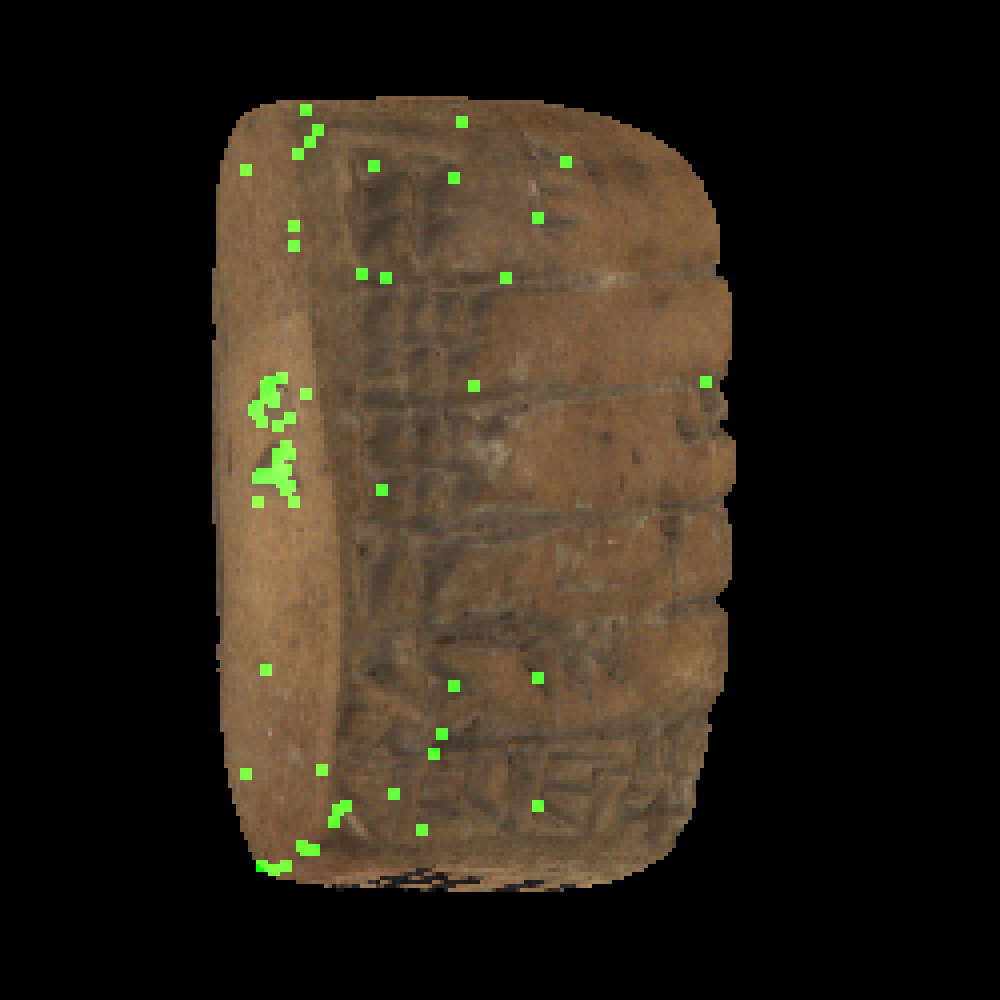

In [ ]:
"""
Visualize the max-pool points on the actual tablet
This has been set-up for left side
"""

def elu(z):
  return np.where( z >= 0, z, np.exp(z) -1 )

# computing when the difference is so high that 
var = [v for v in tf.trainable_variables() if v.name == "cuneiform_left/cla/fc1/weights:0"][0]
output_weight1 = sess.run(var)
var = [v for v in tf.trainable_variables() if v.name == "cuneiform_left/cla/fc1/biases:0"][0]
output_bias1 = sess.run(var)

var = [v for v in tf.trainable_variables() if v.name == "cuneiform_left/cla/fc2/weights:0"][0]
output_weight2 = sess.run(var)
var = [v for v in tf.trainable_variables() if v.name == "cuneiform_left/cla/fc2/biases:0"][0]
output_bias2 = sess.run(var)

var = [v for v in tf.trainable_variables() if v.name == "cuneiform_left/cla/fc3/weights:0"][0]
output_weight3 = sess.run(var)
var = [v for v in tf.trainable_variables() if v.name == "cuneiform_left/cla/fc3/biases:0"][0]
output_bias3 = sess.run(var)

camera = pyrender.OrthographicCamera(xmag=1, ymag=1, zfar=2.0)


scene = pyrender.Scene(bg_color=(0,0,0,0))
r = pyrender.OffscreenRenderer(250, 250)
nc = pyrender.Node(camera=camera)


colors = [[0.5,0.5,0.5],[1,0,0],[0,1,0],[0,0,1]]

check_idx = 31

begidx, endidx = check_idx, check_idx + 1

cat_layer_out = sess.run(
    ["cuneiform_left/cla/res:0", "cuneiform_left/cla/fc1/Elu:0", "cuneiform_left/cla/fc3/BiasAdd:0"], feed_dict={
    pointclouds_ph: cur_data[begidx: endidx, :,:],
    is_training_ph: is_training,
    })

cat_layer_out_max = sess.run(
    ["cuneiform_left/pro/red_1/Max:0", "cuneiform_left/pro/red_2/Max:0", "cuneiform_left/pro/adj_conv7_max/Elu:0", "cuneiform_left/pro/maxpool/cuneiform_left/pro/maxpool:0"], feed_dict={
    pointclouds_ph: cur_data[begidx: endidx, :,:],
    is_training_ph: is_training,
    })

computed1 = elu( np.matmul(cat_layer_out[0], output_weight1) + output_bias1 )
computed2 = elu( np.matmul(computed1, output_weight2) + output_bias2 )
computed3 = np.matmul(computed2, output_weight3) + output_bias3 
computed3_original = computed3.copy()

vertex_colors = []
# color all grey
for point_idx in range(point_num):
    vertex_colors.append(colors[0])
# color activation red

for i in range(1024):
    cat_layer = cat_layer_out[0].copy()
    cat_layer[0, 1024 + i] += 0.1
    computed1 = elu( np.matmul(cat_layer, output_weight1) + output_bias1 )
    computed2 = elu( np.matmul(computed1, output_weight2) + output_bias2 )
    computed3 = np.matmul(computed2, output_weight3) + output_bias3
    comb3 = computed3 - computed3_original
    # print( comb3,  )
    # print( np.where(cat_layer_out_max[2][0,:,0,i] == cat_layer_out_max[3][0,0,0,i])[0][0] )
    if np.abs(comb3[0,0] - comb3[0,1]) < 0.025:
        vertex_colors[ np.where(cat_layer_out_max[2][0,:,0,i] == cat_layer_out_max[3][0,0,0,i])[0][0] ] = colors[3]
    else:
        if comb3[0,0] < comb3[0,1]:
            vertex_colors[ np.where(cat_layer_out_max[2][0,:,0,i] == cat_layer_out_max[3][0,0,0,i])[0][0] ] = colors[2]
        else:
            vertex_colors[ np.where(cat_layer_out_max[2][0,:,0,i] == cat_layer_out_max[3][0,0,0,i])[0][0] ] = colors[1]


scene.clear()
scene.add_node(nc)


fuze_trimesh = trimesh.load('/content/drive/My Drive/HS_2275_GMOCF_r1.50_n4_v512.ply')
fuze_trimesh.apply_scale(1.0/19.683735039067045)
m = pyrender.Mesh.from_trimesh(fuze_trimesh, smooth=False)
obj_h = scene.add(m)

obj_pose = np.eye(4)

obj_pose[2,3] = -2.0
obj_pose[0,2] = 0.7071067811865475
obj_pose[2,0] = -0.7071067811865475
obj_pose[0,0] = 0.7071067811865475
obj_pose[2,2] = 0.7071067811865475
obj_pose[1,3] = -0.806615206336

scene.set_pose(obj_h, pose=obj_pose)
color, depth = r.render(scene, flags=pyrender.constants.RenderFlags.FLAT )
color_cv = cv2.cvtColor(color, cv2.COLOR_RGB2BGR)
color_cv1 = color_cv

obj_pose[2,3] = -2.0
obj_pose[0,2] = 0
obj_pose[2,0] = 0
obj_pose[0,0] = 1
obj_pose[2,2] = 1
obj_pose[1,3] = -0.806615206336


scene.set_pose(obj_h, pose=obj_pose)
color, depth = r.render(scene, flags=pyrender.constants.RenderFlags.FLAT )
color_cv = cv2.cvtColor(color, cv2.COLOR_RGB2BGR)
color_cv2 = color_cv

obj_pose[2,3] = -2.0
obj_pose[0,2] = -1
obj_pose[2,0] = 1
obj_pose[0,0] = 0
obj_pose[2,2] = 0
obj_pose[1,3] = -0.806615206336

scene.set_pose(obj_h, pose=obj_pose)
color, depth = r.render(scene, flags=pyrender.constants.RenderFlags.FLAT )
color_cv = cv2.cvtColor(color, cv2.COLOR_RGB2BGR)
color_cv3 = color_cv

scene.clear()
scene.add_node(nc)

m = pyrender.Mesh.from_points(np.array(cur_data)[check_idx,:,:3], colors=np.array(vertex_colors) )
obj_h = scene.add(m)


obj_pose = np.eye(4)

obj_pose[2,3] = -2.0
obj_pose[0,2] = 0.7071067811865475
obj_pose[2,0] = -0.7071067811865475
obj_pose[0,0] = 0.7071067811865475
obj_pose[2,2] = 0.7071067811865475


scene.set_pose(obj_h, pose=obj_pose)

color, depth = r.render(scene, flags=pyrender.constants.RenderFlags.FLAT )
color_cv = cv2.cvtColor(color, cv2.COLOR_RGB2BGR)
color_cv[:,:,0] *= 0
color_cv[:,:,2] *= 0


color_cv[:,:,1] = cv2.dilate( cv2.threshold( color_cv[:,:,1], 200, 255, cv2.THRESH_BINARY)[1], np.ones((3,3)))

color_cv1_show = cv2.resize( color_cv, ( color_cv.shape[1]*4, color_cv.shape[0]*4 ), interpolation=cv2.INTER_NEAREST )

color_cv1[:,:,1] = color_cv1[:,:,1] * (1-color_cv[:,:,1]/255) + (color_cv[:,:,1])

color_cv1 = cv2.resize( color_cv1, ( color_cv.shape[1]*4, color_cv.shape[0]*4 ), interpolation=cv2.INTER_NEAREST )

cv2_imshow(color_cv1)